In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# Classifying with Sorted Spikes

In this tutorial, we will use the classifier to identify the dynamics of the latent position trajectory.

### Set Plotting Defaults

In [3]:
import logging
import os

import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Set background and fontsize
rc_params = {
    'pdf.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'ps.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'axes.labelcolor': '#222222',
    'axes.labelsize': 9,
    'text.color': '#222222',
    'font.sans-serif' : 'Helvetica',
    'text.usetex': False,
    'figure.figsize': (7.2, 4.45),
    'xtick.major.size': 0.00,
    'ytick.major.size': 0.00,
    'axes.labelpad': 0.1,
    }
sns.set(style='white', context='paper', rc=rc_params,
        font_scale=1.0)

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)

## Simulate Sorted Spikes Data

First let's simulate some data to train the encoding model on.

In [103]:
time, linear_distance, sampling_frequency, spikes, place_fields = make_simulated_run_data()

time.shape,linear_distance.shape,spikes.shape,place_fields.shape

((360000,), (360000,), (360000, 19), (360000, 19))

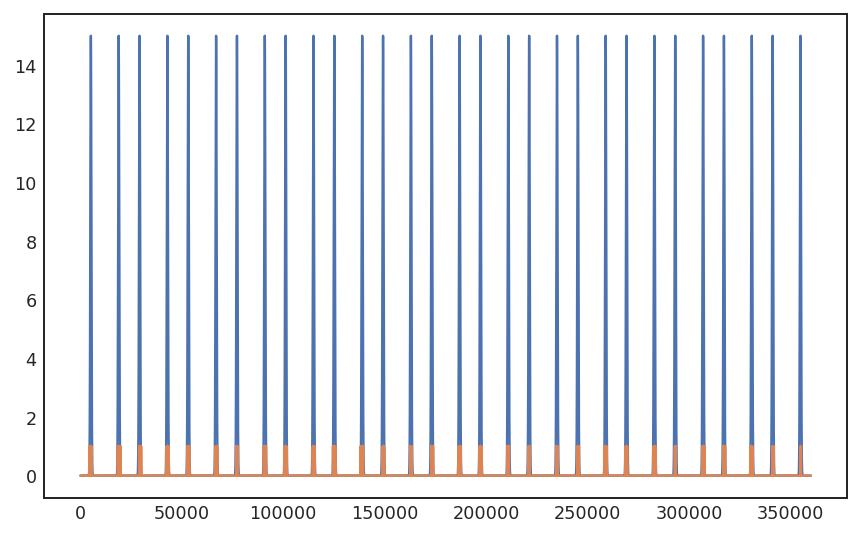

In [104]:
# plt.plot(place_fields[:,0])
# plt.plot(place_fields[:,1])
plt.plot(place_fields[:,7])
plt.plot(spikes[:,7])

plt.show()

In [102]:
bst.data[0,:].max() * 0.001

0.001

In [105]:
from ripple_heterogeneity.utils import functions, loading, compress_repeated_epochs
import statistics
import nelpy as nel
basepath = r"Z:\Data\GrosmarkAD\Achilles\Achilles_11012013"
beh_df = loading.load_animal_behavior(basepath)
beh_df.linearized = beh_df.linearized.interpolate(
    method="linear",
    limit=int(1 / statistics.mode(np.diff(beh_df.time))) * 5,
)
time = np.arange(beh_df['time'].min(), beh_df['time'].max(), 1/1000)
linear_distance = np.interp(time, beh_df['time'], beh_df['linearized'])

# load session epoch data
epoch_df = loading.load_epoch(basepath)
# put into nel format
beh_epochs = nel.EpochArray([np.array([epoch_df.startTime, epoch_df.stopTime]).T])
idx = epoch_df.environment == "linear"
beh_epochs_linear = beh_epochs[idx]
session_bounds = nel.EpochArray(
    [time.min(), time.max()+1/1000]
)
st,cell_metrics = loading.load_spikes(basepath, brainRegion='CA1', putativeCellType='Pyr')
bst = st[session_bounds].bin(ds=1/1000)

spikes = ((bst.data > 0)*1).T
place_fields = (bst.data).T

sampling_frequency = 1000

In [159]:
bad_idx = np.isnan(linear_distance)
time = time[~bad_idx]
linear_distance = linear_distance[~bad_idx]
spikes = spikes[~bad_idx,:]
place_fields = place_fields[~bad_idx,:]

speed = np.gradient(linear_distance) * sampling_frequency

bad_idx = speed < 4
time = time[~bad_idx]
linear_distance = linear_distance[~bad_idx]
spikes = spikes[~bad_idx,:]
place_fields = place_fields[~bad_idx,:]

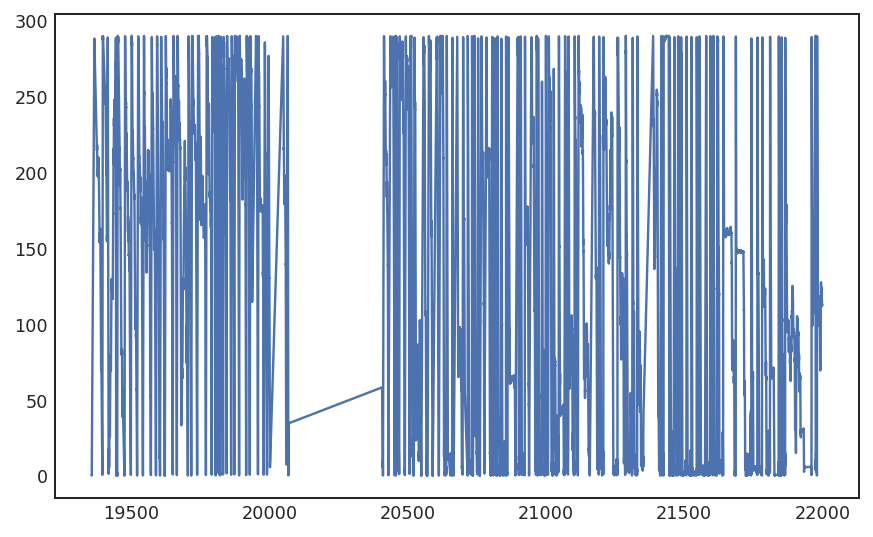

In [170]:
plt.plot(time, linear_distance)

In [171]:
from replay_trajectory_classification import SortedSpikesDecoder
from replay_trajectory_classification.state_transition import estimate_movement_var
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk

movement_var = estimate_movement_var(linear_distance, sampling_frequency)

environment = Environment(place_bin_size=1)
transition_type = RandomWalk(movement_var=movement_var)

decoder = SortedSpikesDecoder(
    environment=environment,
    transition_type=transition_type)
decoder.fit(linear_distance, spikes)

INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting place fields...


SortedSpikesDecoder(environment=Environment(environment_name='', place_bin_size=1, track_graph=None, edge_order=None, edge_spacing=None, is_track_interior=None, position_range=None, infer_track_interior=True),
                    infer_track_interior=True,
                    initial_conditions_type=UniformInitialConditions(),
                    knot_spacing=10, spike_model_penalty=10.0,
                    transition_type=RandomWalk(environment_name='', movement_var=8223.498852329802, movement_mean=0.0, use_diffusion=True))

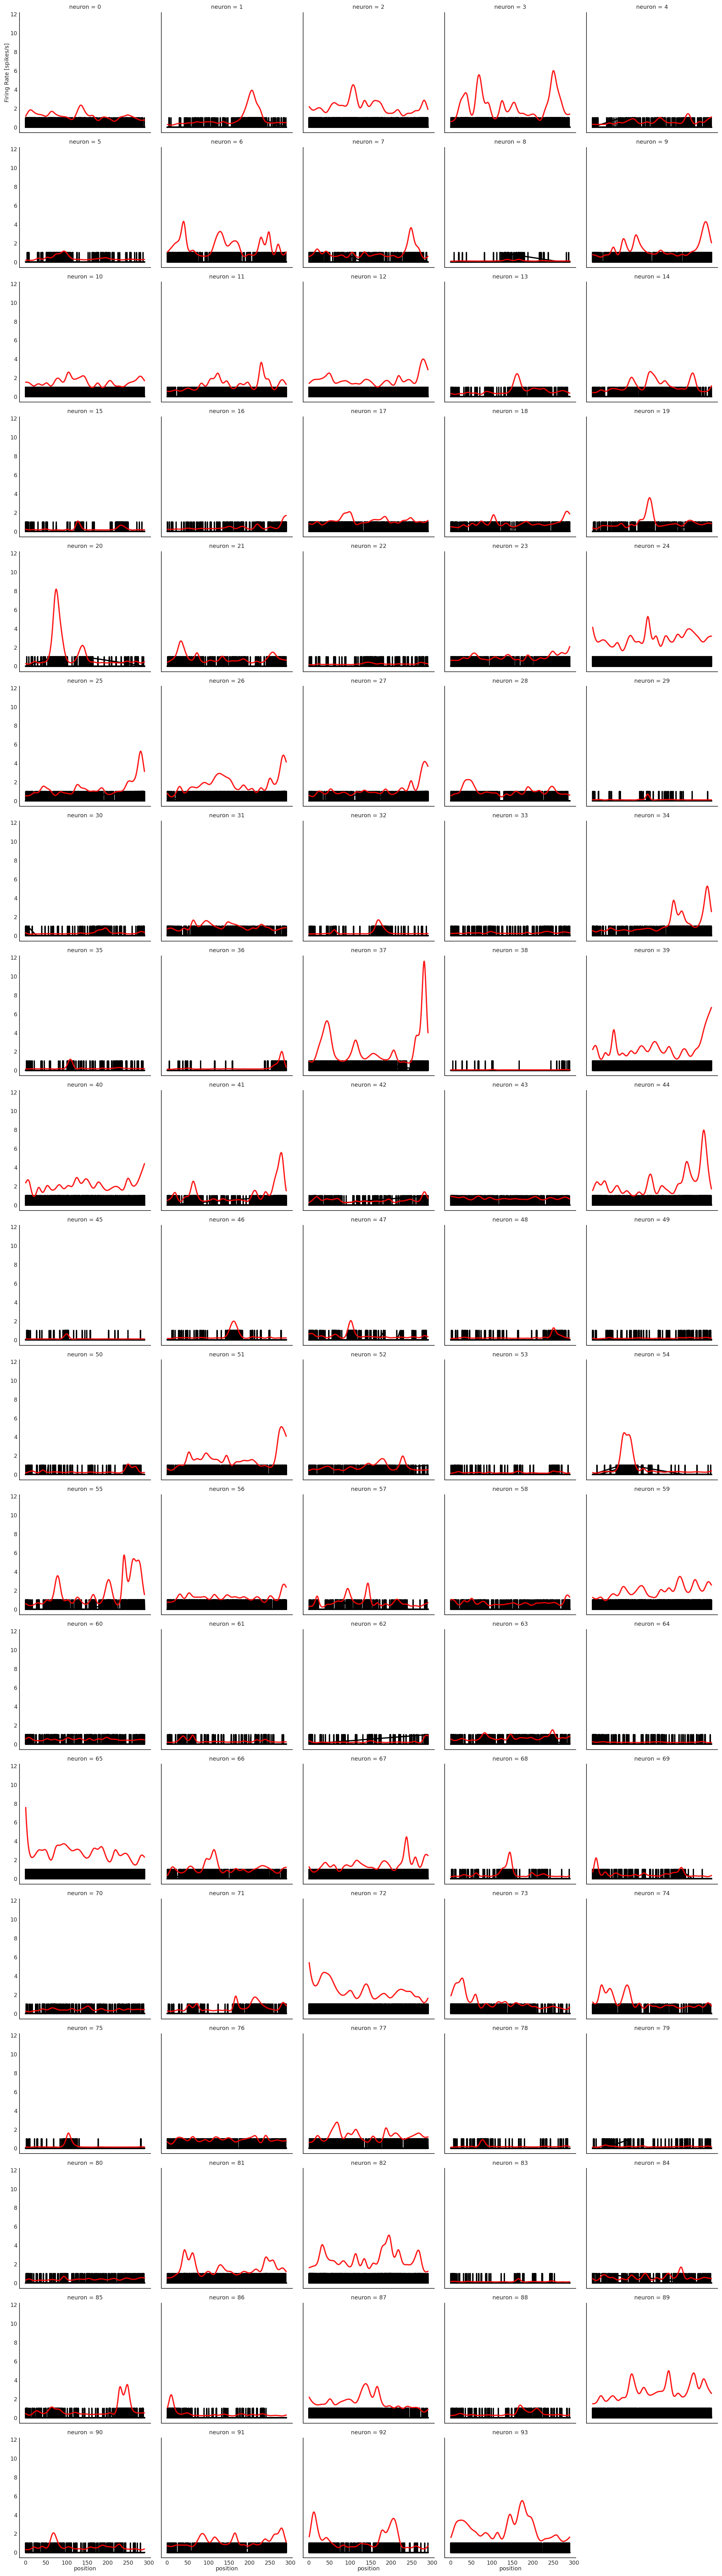

In [172]:
g = (decoder.place_fields_ * sampling_frequency).plot(
        x="position", col="neuron", col_wrap=5, color="red", linewidth=2, alpha=0.9, zorder=1, label="Predicted")
g.axes[0, 0].set_ylabel("Firing Rate [spikes/s]")
for ax, place_field in zip(g.axes.flat, place_fields.T):
    ax.plot(linear_distance, place_field, linewidth=2, color="black", zorder=-1, label="True")
sns.despine()

In [121]:
time.shape

(2140314,)

In [173]:
time_ind = slice(50000, 50000*2)

results = decoder.predict(spikes[time_ind], time=time[time_ind])
results

INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...


<xarray.Dataset>
Dimensions:            (time: 50000, position: 290)
Coordinates:
  * time               (time) float64 1.952e+04 1.952e+04 ... 1.968e+04
  * position           (position) float64 0.4999 1.5 2.5 ... 287.5 288.5 289.5
Data variables:
    likelihood         (time, position) float64 0.9984 0.9993 ... 0.9629 0.9656
    causal_posterior   (time, position) float64 0.003512 0.003515 ... 0.002243
    acausal_posterior  (time, position) float64 0.002365 0.002388 ... 0.002243
Attributes:
    data_log_likelihood:  -5675.14658109721

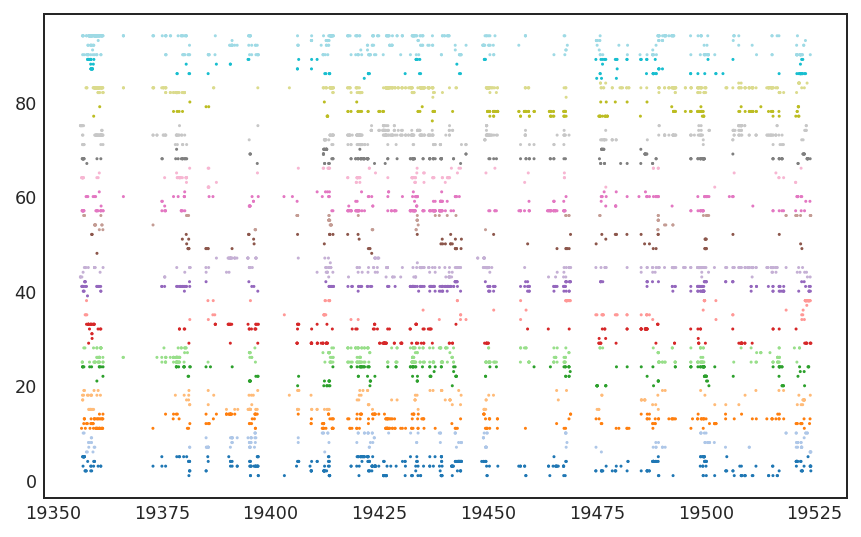

In [177]:
plt.scatter(time[spike_ind], neuron_ind + 1, c=c, s=0.5, clip_on=False)


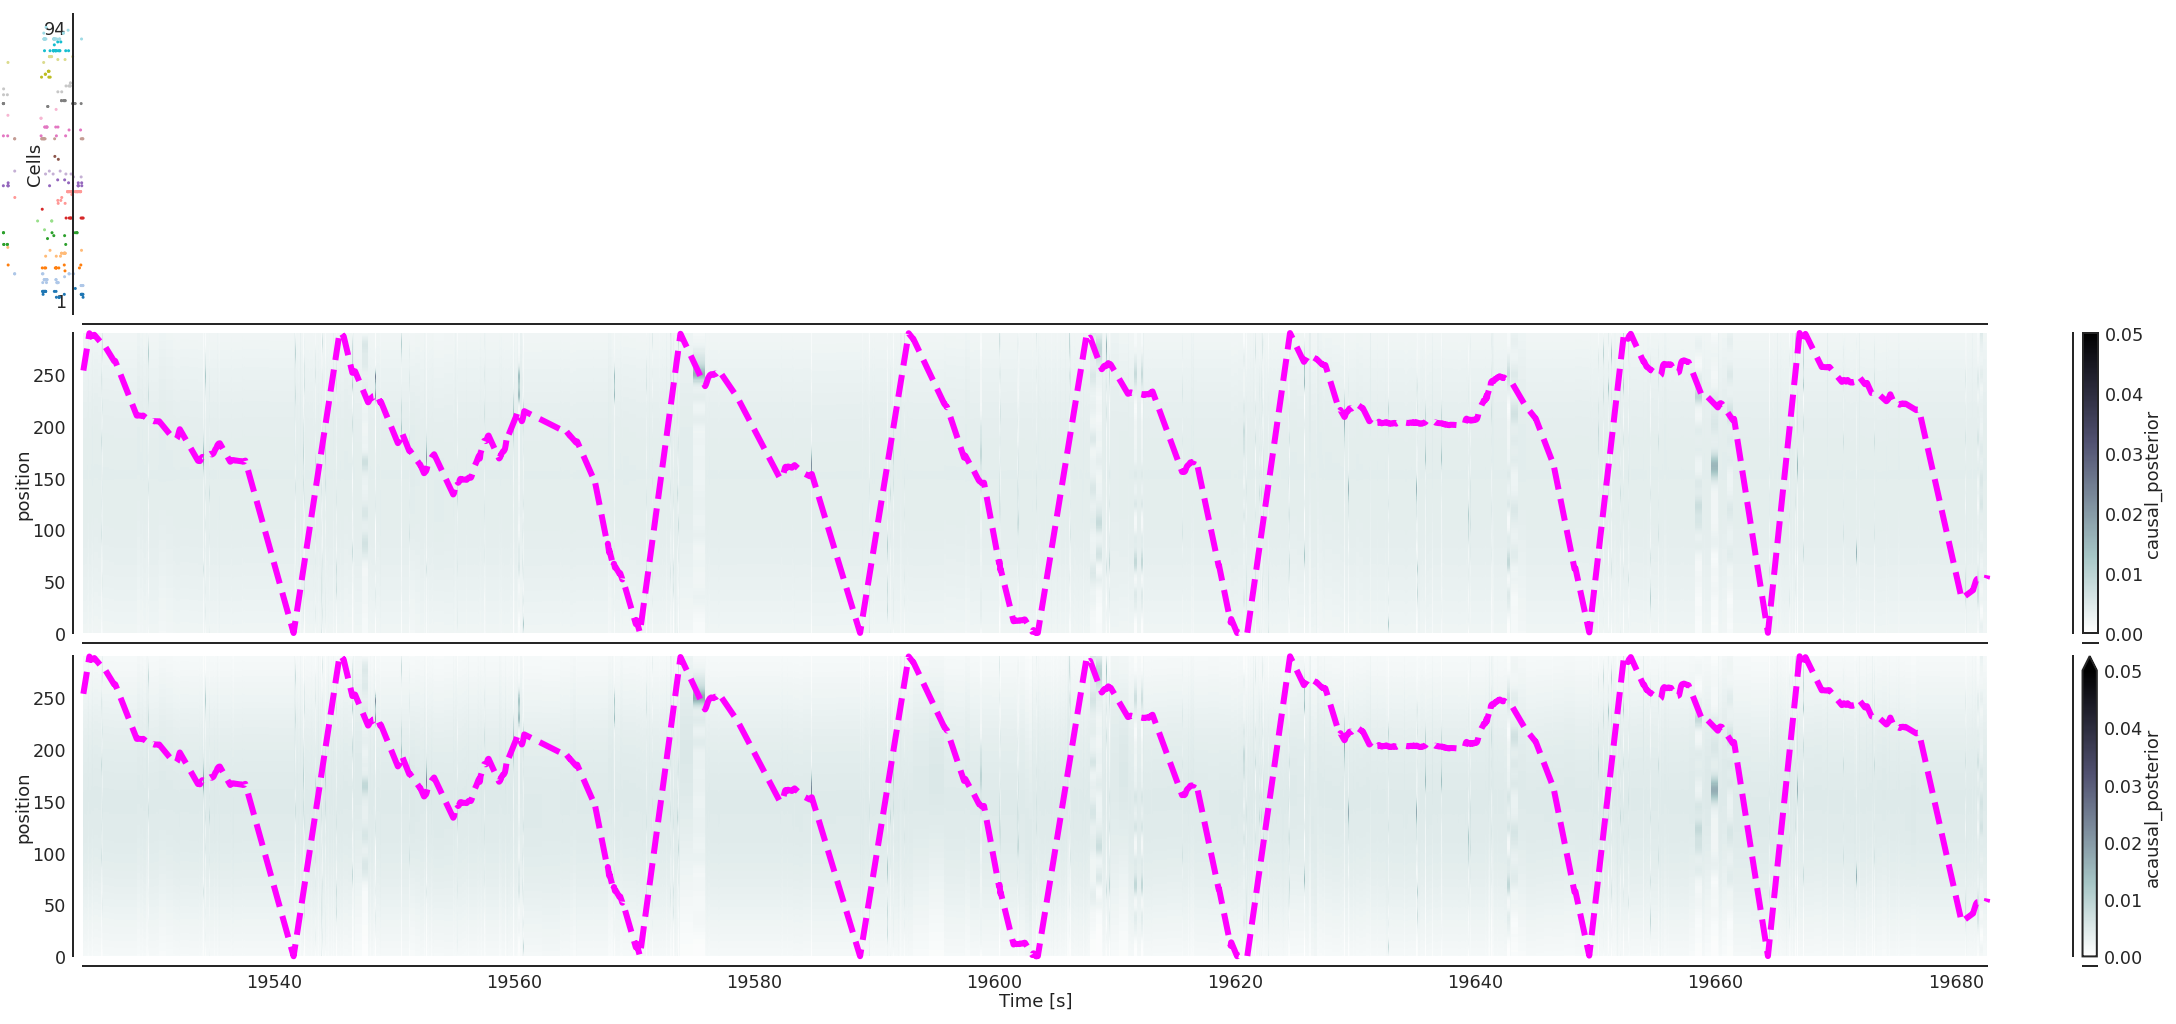

In [175]:
fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15, 7))

spike_ind, neuron_ind = np.nonzero(spikes[time_ind])
c = [cmap.colors[ind] for ind in neuron_ind]
axes[0].scatter(time[spike_ind], neuron_ind + 1, c=c, s=0.5, clip_on=False)
axes[0].set_yticks((1, spikes.shape[1]))
axes[0].set_ylabel('Cells')

results.causal_posterior.plot(x="time", y="position", ax=axes[1], cmap="bone_r", vmin=0.0, vmax=0.05, clip_on=False)
axes[1].plot(time[time_ind], linear_distance[time_ind], color="magenta", linestyle="--", linewidth=3, clip_on=False)
axes[1].set_xlabel("")
results.acausal_posterior.plot(x="time", y="position", ax=axes[2], cmap="bone_r", vmin=0.0, vmax=0.05, clip_on=False)
axes[2].plot(time[time_ind], linear_distance[time_ind], color="magenta", linestyle="--", linewidth=3, clip_on=False)
axes[2].set_xlabel('Time [s]')
sns.despine(offset=5)

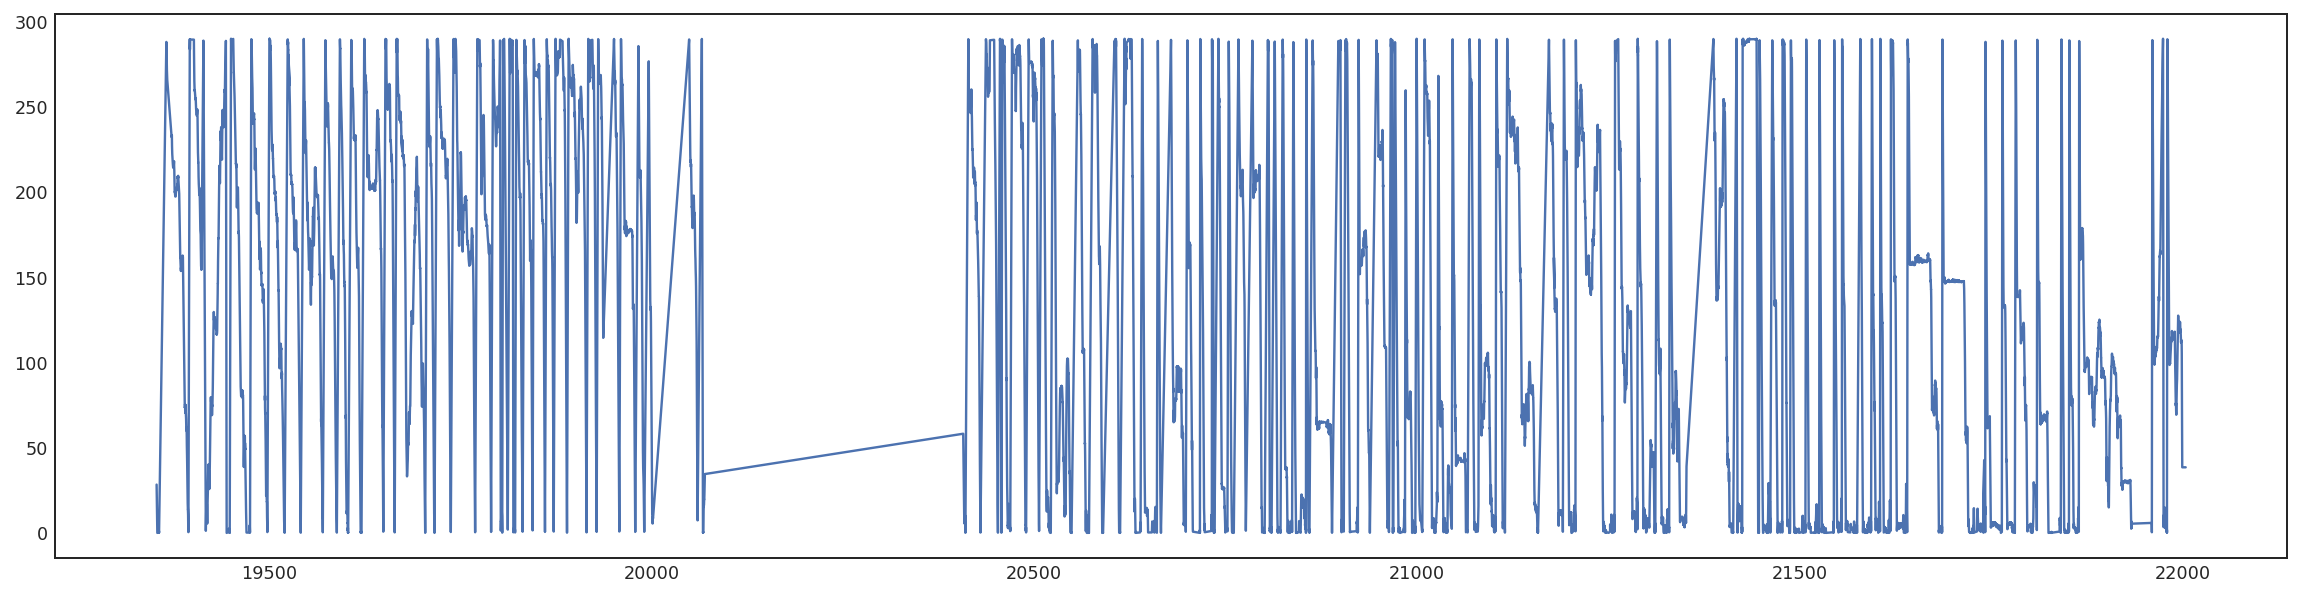

In [76]:
plt.figure(figsize=(20,5))
plt.plot(time, linear_distance)
sampling_frequency = 1000

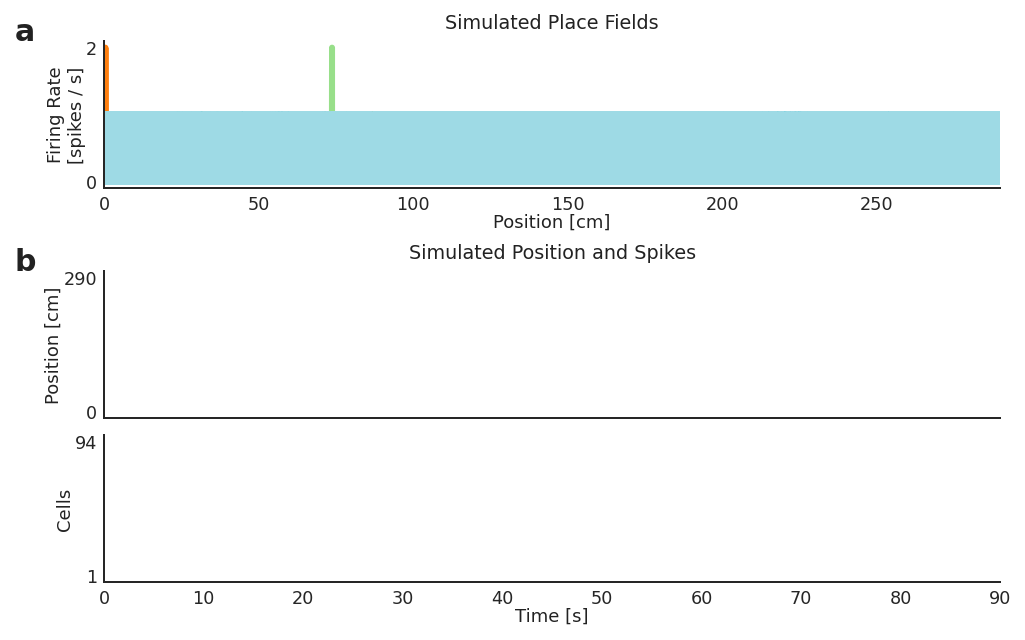

In [116]:
from replay_trajectory_classification.sorted_spikes_simulation import make_simulated_run_data
from replay_trajectory_classification.misc import TWO_COLUMN, GOLDEN_RATIO

# time, linear_distance, sampling_frequency, spikes, place_fields = make_simulated_run_data()
spike_ind, neuron_ind = np.nonzero(spikes)
cmap = plt.get_cmap('tab20',spikes.shape[1])

fig, axes = plt.subplots(3, 1, figsize=(TWO_COLUMN, TWO_COLUMN * GOLDEN_RATIO), constrained_layout=True)
for place_field, color in zip(place_fields.T, cmap.colors):
    axes[0].plot(linear_distance, place_field, linewidth=3, color=color)
axes[0].set_xlabel('Position [cm]')
axes[0].set_ylabel('Firing Rate\n[spikes / s]')
axes[0].set_title('Simulated Place Fields')
axes[0].set_xlim((linear_distance.min(), linear_distance.max()))
axes[0].set_yticks([0, np.round(place_fields.max())])
axes[0].text(-0.10, 1.0, 'a', transform=axes[0].transAxes, 
        size=15, weight='extra bold')

axes[1].plot(time, linear_distance, linewidth=3)
axes[1].set_ylabel('Position [cm]')
axes[1].set_title('Simulated Position and Spikes')
axes[1].set_yticks([0, np.round(linear_distance.max())])
axes[1].set_xticks([])
axes[1].set_xlim((0.0, 90.0))
axes[1].text(-0.10, 1.0, 'b', transform=axes[1].transAxes, 
        size=15, weight='extra bold')

c = [cmap.colors[ind] for ind in neuron_ind]
axes[2].scatter(time[spike_ind], neuron_ind + 1, c=c, s=0.5)
axes[2].set_yticks((1, spikes.shape[1]))
axes[2].set_ylabel('Cells')

axes[2].set_xlabel('Time [s]')
axes[2].set_xlim((0.0, 90.0))

sns.despine()

In [7]:
from dask.distributed import Client

Client(n_workers=2,
       threads_per_worker=2,
       processes=True,
       memory_limit='25GB')

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\distributed\node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60827 instead


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:60827/status,
Dashboard: http://127.0.0.1:60827/status,Workers: 2
Total threads: 4,Total memory: 46.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60828,Workers: 2
Dashboard: http://127.0.0.1:60827/status,Total threads: 4
Started: Just now,Total memory: 46.57 GiB
Comm: tcp://127.0.0.1:60846,Total threads: 2
Dashboard: http://127.0.0.1:60847/status,Memory: 23.28 GiB
Nanny: tcp://127.0.0.1:60832,


## Fit Sorted Spikes Classifier

Next we will fit the model on the position and the spikes. This will encode the relationship between spikes and position (aka the place field maps).

The `continuous_transition_types` parameter is a 3x3 matrix (because we have three dynamics: continuous, fragmented, and stationary). This governs how the position will change when in a given dynamic or when transitioning between dynamics.

The `discrete_transition_diag` also creates a transition matrix between dynamics, defining how likely the model is, on average, to stay in the dynamic or change.

In [8]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform, Identity


movement_var = estimate_movement_var(linear_distance, sampling_frequency)

environment = Environment(place_bin_size=np.sqrt(movement_var))
continuous_transition_types = [[RandomWalk(movement_var=movement_var * 120),  Uniform(), Identity()],
                                [Uniform(),                                   Uniform(), Uniform()],
                                [RandomWalk(movement_var=movement_var * 120), Uniform(), Identity()],
                               ]

classifier = SortedSpikesClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    spike_model_penalty=0.5,
)
classifier.fit(linear_distance, spikes)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting continuous state transition...
INFO:replay_trajectory_classification.classifier:Fitting discrete state transition
INFO:replay_trajectory_classification.classifier:Fitting place fields...


SortedSpikesClassifier(continuous_transition_types=[[RandomWalk(environment_name='', movement_var=18288.789096975073, movement_mean=0.0, use_diffusion=True),
                                                     Uniform(environment_name='', environment2_name=None),
                                                     Identity(environment_name='')],
                                                    [Uniform(environment_name='', environment2_name=None),
                                                     Uniform(environment_name='', environment2_name=None),
                                                     Uniform(...
                       environments=(Environment(environment_name='', place_bin_size=12.345305820761412, track_graph=None, edge_order=None, edge_spacing=None, is_track_interior=None, position_range=None, infer_track_interior=True),),
                       infer_track_interior=True,
                       initial_conditions_type=UniformInitialConditions(),
            

We can plot the place fields.

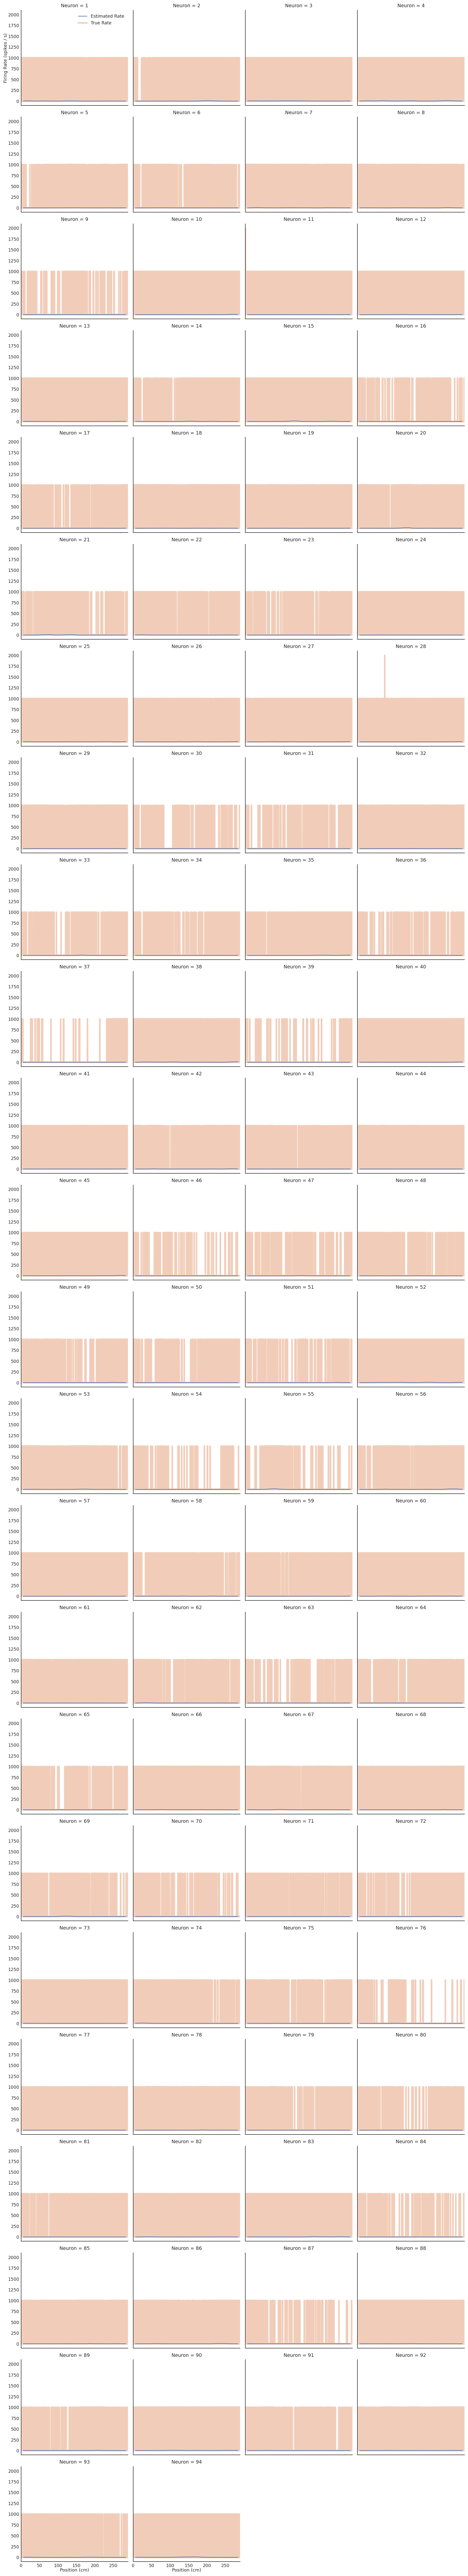

In [9]:
g = (classifier.place_fields_['', 0] * sampling_frequency).plot(x='position', col='neuron', col_wrap=4, label='Estimated Rate')
for ind, (ax, true_field) in enumerate(zip(g.axes.flat, place_fields.T)):
    ax.plot(linear_distance, true_field, linestyle='-',
            zorder=0, linewidth=3, alpha=0.4, label='True Rate')
    ax.set_xlim((linear_distance.min(), linear_distance.max()))
    ax.set_title(f'Neuron = {ind + 1}')
sns.despine()

g.axes[0, 0].set_ylabel('Firing Rate (spikes / s)')
g.axes[0, 0].legend(frameon=False)

for ax in g.axes[-1]:
    ax.set_xlabel('Position (cm)')

After we have fit the model, we can plot transition matrices that were constructed as specified by `continuous_transition_types`.

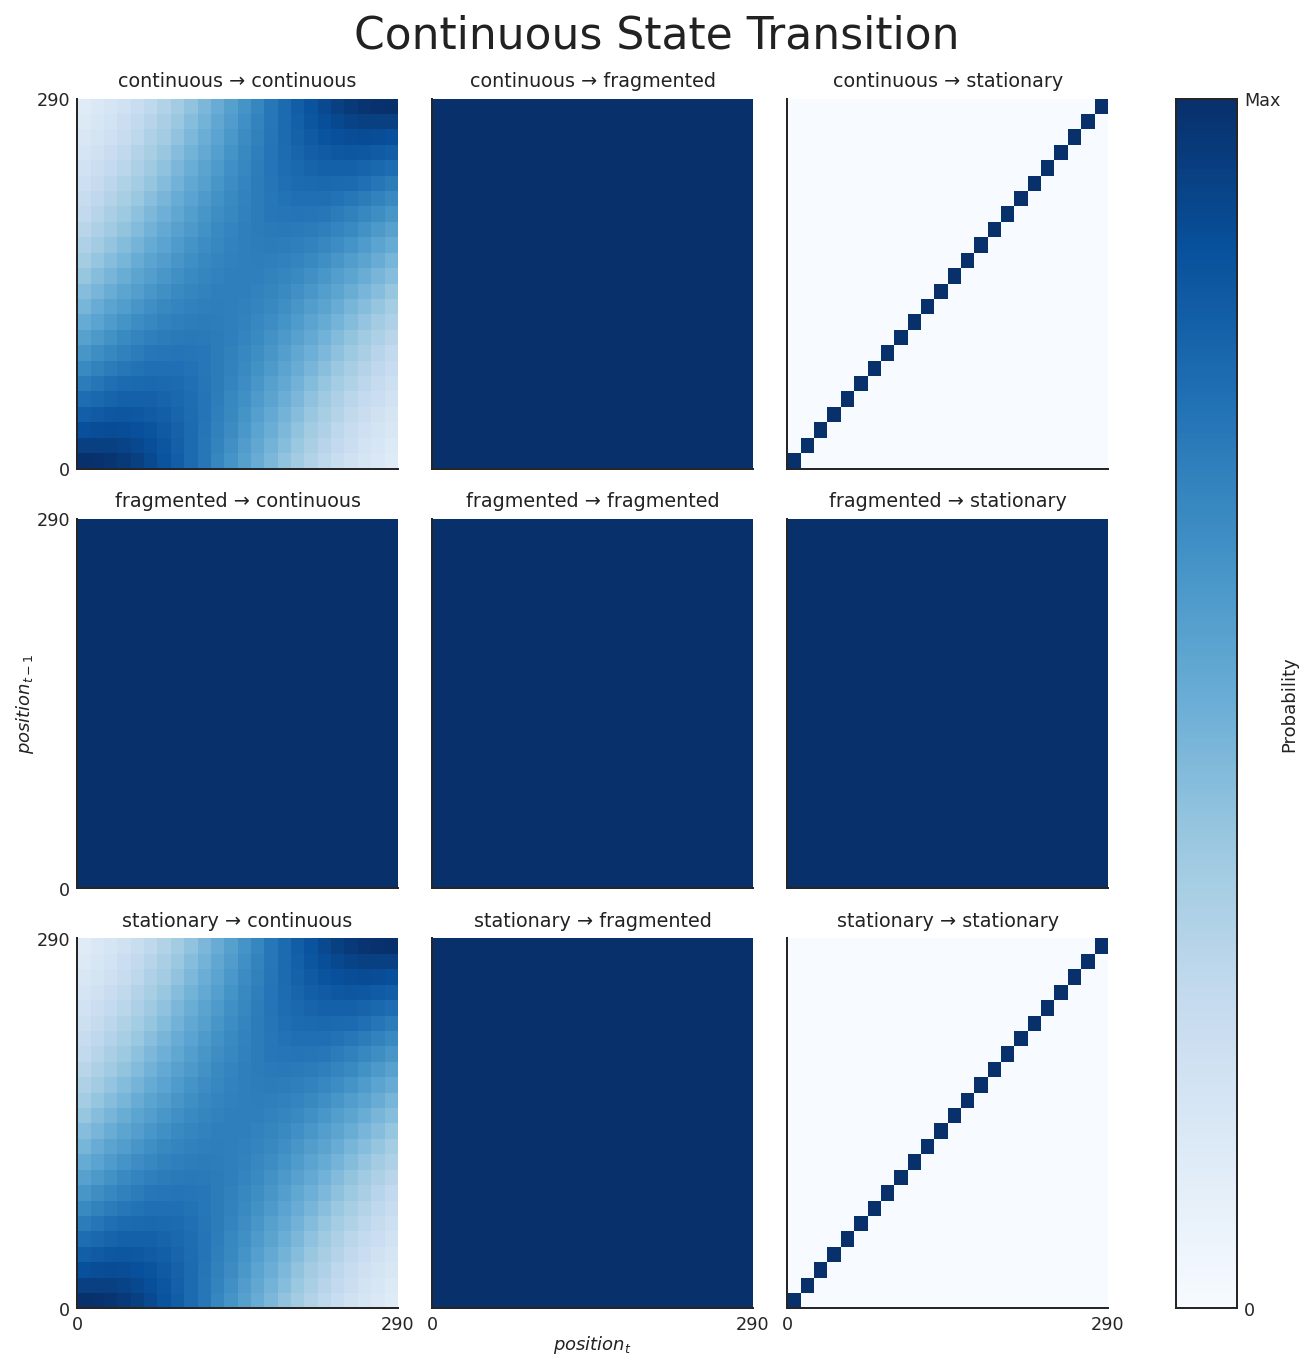

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9),
                         sharex=True, sharey=True,
                         constrained_layout=True)
continuous_transition_types = np.asarray(classifier.continuous_transition_types)
x, y = np.meshgrid(environment.place_bin_edges_, environment.place_bin_edges_)
state_names = ['continuous', 'fragmented', 'stationary']
bin_min, bin_max = linear_distance.min(), linear_distance.max()

for j in range(3):
    for k in range(3):
        im = axes[j, k].pcolormesh(x, y, classifier.continuous_state_transition_[j, k], cmap='Blues',
                                   vmin=0.0, vmax=classifier.continuous_state_transition_[j, k].max())
        # axes[j, k].text(1, 175, continuous_transition_types[j, k].replace('_', ' '), color='grey',
        #                 va='top', fontsize=14)
        axes[j, k].set_title(f'{state_names[j]} → {state_names[k]}')
        axes[j, k].set_xticks((bin_min, bin_max))
        axes[j, k].set_yticks((bin_min, bin_max))
        
plt.xlim((bin_min, bin_max))
plt.ylim((bin_min, bin_max))
axes[1, 0].set_ylabel(r'$position_{t-1}$')
axes[-1, 1].set_xlabel(r'$position_{t}$')
plt.suptitle('Continuous State Transition', y=1.04, fontsize=22)
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), ticks=[0, 1], label='Probability')
cbar.ax.set_yticklabels(['0', 'Max'])
sns.despine()

We can also plot the transition matrix between the dynamics

Text(0.5, 1.0, 'Discrete State Transition')

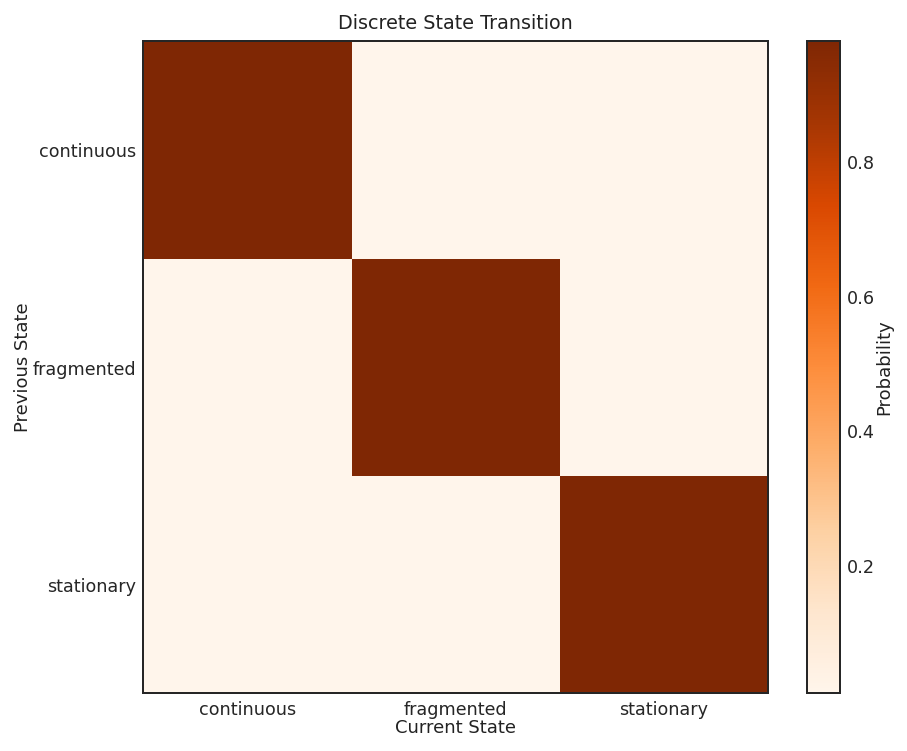

In [12]:
state_names = ['continuous', 'fragmented', 'stationary']
edges = np.arange(0.5, 4.5)
x_edges, y_edges = np.meshgrid(edges, edges)
plt.figure(figsize=(7, 6))
plt.pcolormesh(x_edges, y_edges, np.fliplr(classifier.discrete_state_transition_), cmap='Oranges')
plt.xticks(ticks=range(1, 4), labels=state_names)
plt.yticks(ticks=range(1, 4), labels=state_names[::-1])
plt.colorbar(label='Probability')
plt.ylabel('Previous State')
plt.xlabel('Current State')
plt.title('Discrete State Transition')

## Test classifier on different replay types 

Now we can see how this model works on different types of replay dynamics

In [13]:
from replay_trajectory_classification.misc import TRANSITION_TO_CATEGORY, STATE_COLORS

def plot_classification(replay_time, test_spikes, results):
    fig, axes = plt.subplots(3, 1, figsize=(10, 6), constrained_layout=True, sharex=True)
    spike_time_ind, neuron_ind = np.nonzero(test_spikes)
    axes[0].scatter(replay_time[spike_time_ind], neuron_ind, color='black', zorder=1,
                    marker='|', s=80, linewidth=3)
    axes[0].set_yticks((0, test_spikes.shape[1]))
    axes[0].set_ylabel('Neuron Index')
    replay_probability = results.acausal_posterior.sum('position')
    for state, prob in replay_probability.groupby('state'):
        axes[1].plot(prob.time, prob.values, linewidth=4, label=state, color=STATE_COLORS[state])
    axes[1].set_ylabel('Probability')
    axes[1].set_yticks([0, 1])
    axes[1].set_ylim((-0.01, 1.05))
    axes[1].legend(bbox_to_anchor=(1.15, 0.95), loc='upper right', fancybox=False, shadow=False,
                   ncol=1, frameon=False)
    
    results.acausal_posterior.sum('state').plot(
        x='time', y='position', robust=True, vmin=0.0, ax=axes[2])
    axes[2].set_ylabel('Position [cm]')
    plt.xlim((replay_time.min(), replay_time.max()))
    axes[-1].set_xlabel('Time [ms]')
    sns.despine()

In [27]:
ripples

,start,stop,peaks,amplitude,duration,frequency,detectorName,ripple_channel,event_spk_thres,basepath,basename,animal
0,13.1320,13.1760,13.1400,139.328413,0.0440,143.824138,bz_DetectSWR,87,1,Z:\Data\GrosmarkAD\Achilles\Achilles_11012013,Achilles_11012013,Achilles
1,14.7816,14.8664,14.8232,778.995417,0.0848,188.935335,bz_DetectSWR,87,1,Z:\Data\GrosmarkAD\Achilles\Achilles_11012013,Achilles_11012013,Achilles
2,18.0272,18.1152,18.0656,540.813901,0.0880,145.285304,bz_DetectSWR,87,1,Z:\Data\GrosmarkAD\Achilles\Achilles_11012013,Achilles_11012013,Achilles
3,20.2632,20.3192,20.3088,338.686680,0.0560,139.951022,bz_DetectSWR,87,1,Z:\Data\GrosmarkAD\Achilles\Achilles_11012013,Achilles_11012013,Achilles
4,20.5400,20.5808,20.5696,512.164855,0.0408,138.409033,bz_DetectSWR,87,1,Z:\Data\GrosmarkAD\Achilles\Achilles_11012013,Achilles_11012013,Achilles
...,...,...,...,...,...,...,...,...,...,...,...,...
10051,36612.1896,36612.2416,36612.2296,341.710677,0.0520,132.776483,bz_DetectSWR,87,1,Z:\Data\GrosmarkAD\Achilles\Achilles_11012013,Achilles_11012013,Achilles
10052,36613.8728,36613.9944,36613.9040,537.999633,0.1216,136.792721,bz_DetectSWR,87,1,Z:\Data\GrosmarkAD\Achilles\Achilles_11012013,Achilles_11012013,Achilles
10053,36615.0336,36615.1000,36615.0592,471.141872,0.0664,141.733405,bz_DetectSWR,87,1,Z:\Data\GrosmarkAD\Achilles\Achilles_11012013,Achilles_11012013,Achilles
10054,36615.7320,36615.7856,36615.7736,302.224797,0.0536,114.302630,bz_DetectSWR,87,1,Z:\Data\GrosmarkAD\Achilles\Achilles_11012013,Achilles_11012013,Achilles


In [29]:
basepath = r"Z:\Data\GrosmarkAD\Achilles\Achilles_11012013"
ripples = loading.load_ripples_events(basepath)
beh_df = loading.load_animal_behavior(basepath)
beh_df.linearized = beh_df.linearized.interpolate(
    method="linear",
    limit=int(1 / statistics.mode(np.diff(beh_df.time))) * 5,
)
time = np.arange(beh_df['time'].min(), beh_df['time'].max(), 1/1000)
linear_distance = np.interp(time, beh_df['time'], beh_df['linearized'])

# load session epoch data
epoch_df = loading.load_epoch(basepath)
# put into nel format
beh_epochs = nel.EpochArray([np.array([epoch_df.startTime, epoch_df.stopTime]).T])
idx = epoch_df.environment == "linear"
beh_epochs_linear = beh_epochs[idx]
session_bounds = nel.EpochArray(
    [time.min(), time.max()+1/1000]
)
st,cell_metrics = loading.load_spikes(basepath, brainRegion='CA1', putativeCellType='Pyr')
bst = st[session_bounds].bin(ds=1/1000)

spikes = ((bst.data > 0)*1).T
place_fields = (bst.data).T

sampling_frequency = 1000

4137

In [ ]:
np.where((ripples.start.values > min(time)) & (ripples.start.values < max(time)))[0].shape


In [73]:

rip = np.where((ripples.start.values > min(time)) & (ripples.start.values < max(time)))[0][320]

idx = (time >= ripples.iloc[rip].start-0.05) & (time <= ripples.iloc[rip].stop+0.05)
test_spikes = spikes[idx,:]
replay_time = time[idx]
state_names = ['continuous', 'fragmented', 'stationary']

test_spikes.shape, replay_time.shape

((142, 94), (142,))

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


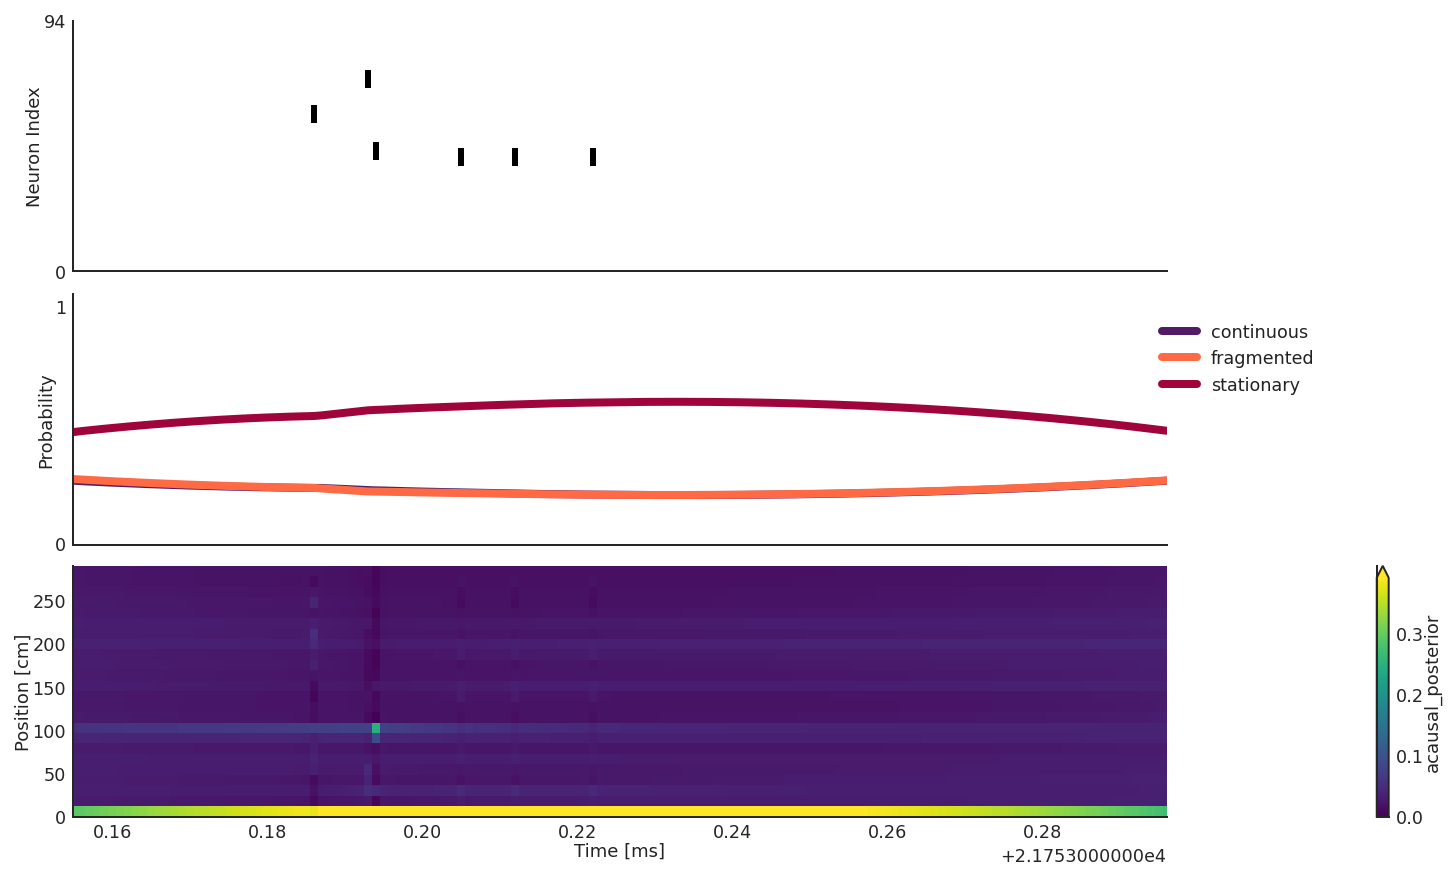

In [74]:
results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)

In [ ]:
# replay_time, test_spikes = make_continuous_replay()


In [20]:
from replay_trajectory_classification.sorted_spikes_simulation import make_continuous_replay

replay_time, test_spikes = make_continuous_replay()
replay_time.shape

(100,)

### Continuous

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


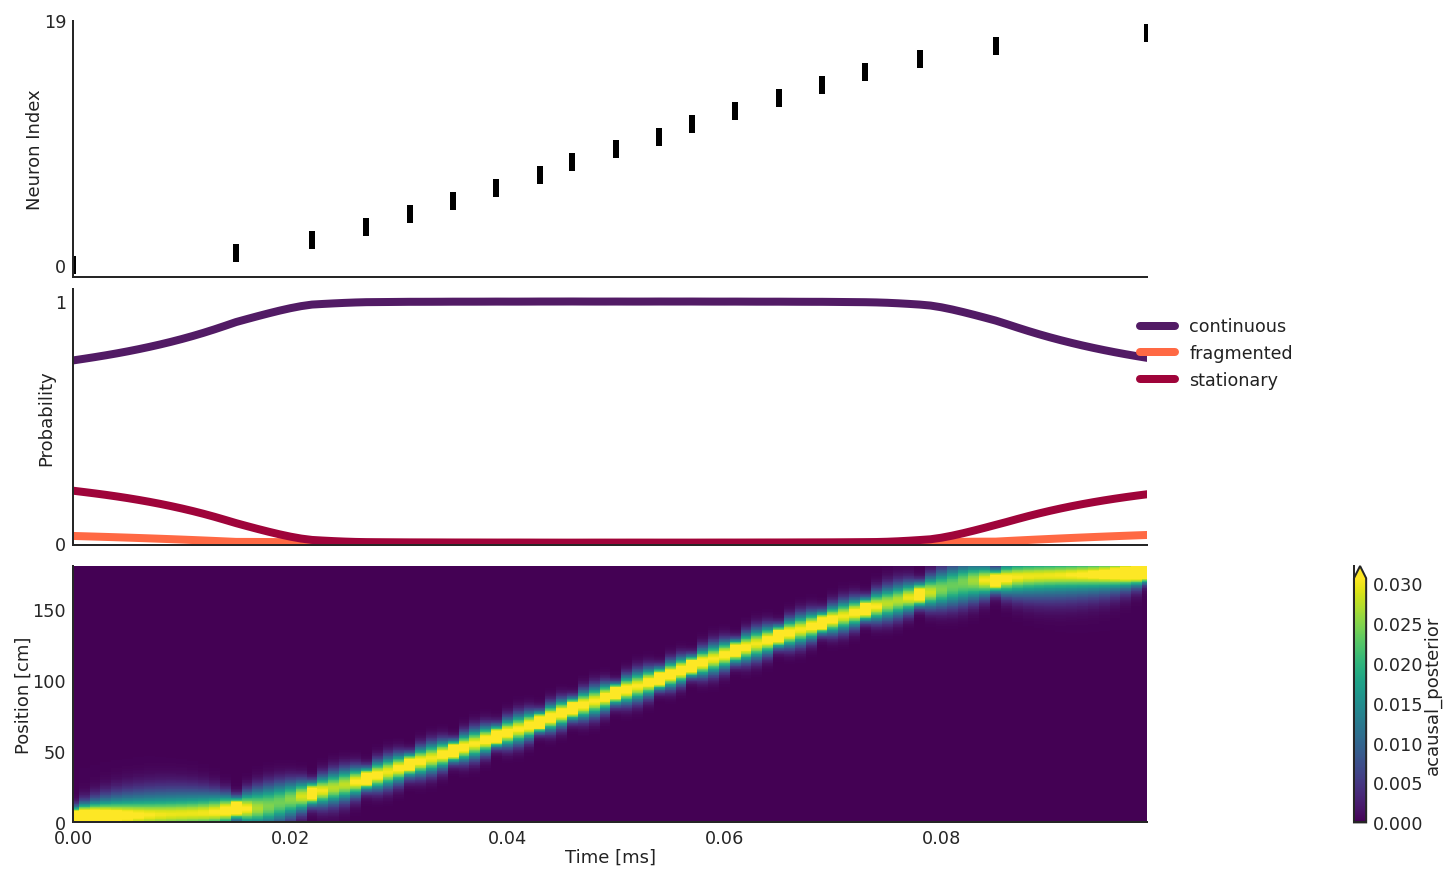

In [10]:
from replay_trajectory_classification.sorted_spikes_simulation import make_continuous_replay

replay_time, test_spikes = make_continuous_replay()
state_names = ['continuous', 'fragmented', 'stationary']
results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)

### Stationary

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


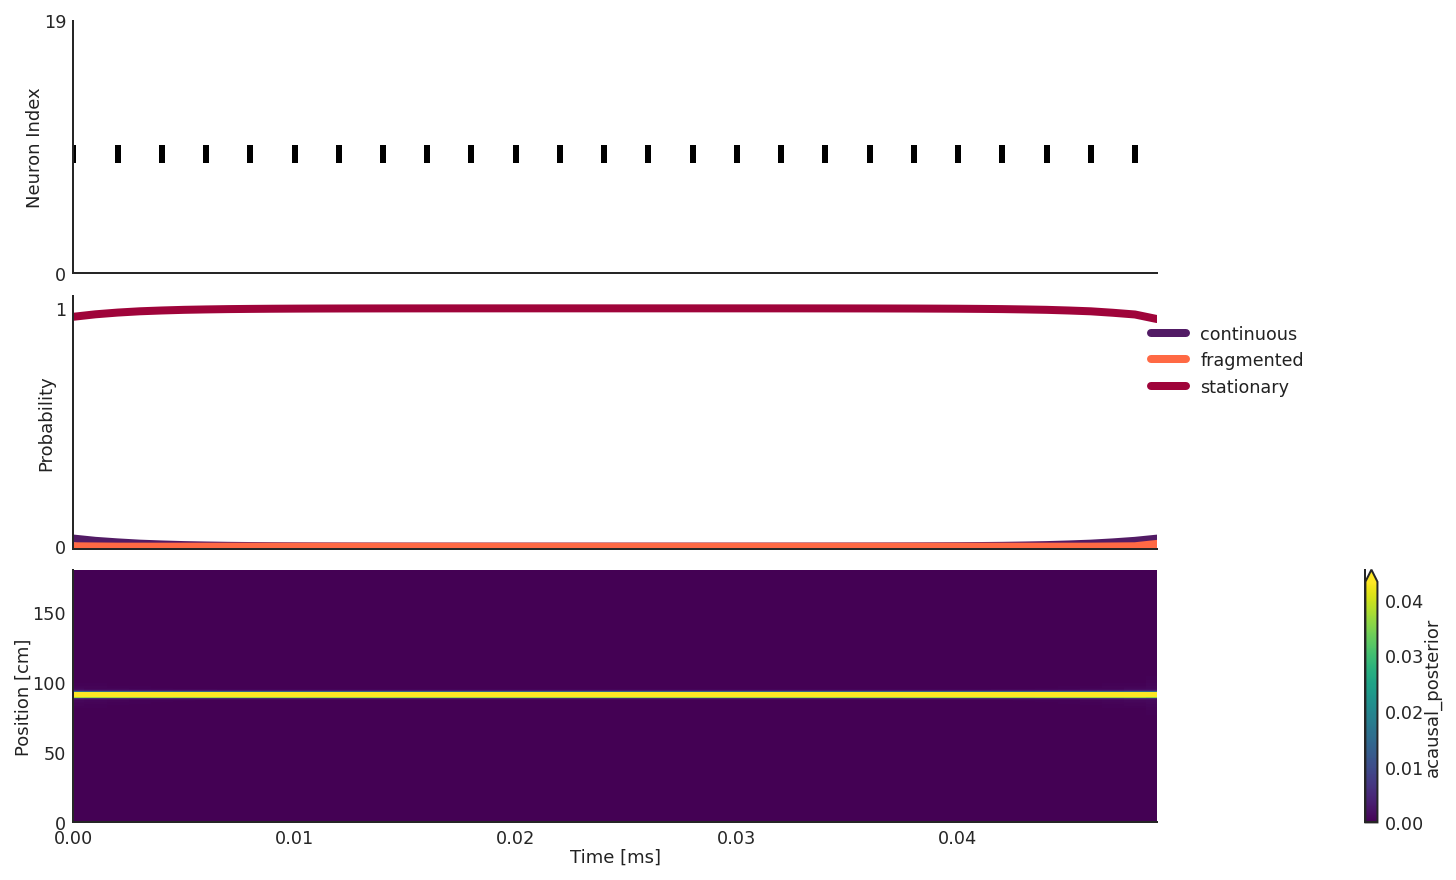

In [11]:
from replay_trajectory_classification.sorted_spikes_simulation import make_hover_replay

replay_time, test_spikes = make_hover_replay()

results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)

### Fragmented

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


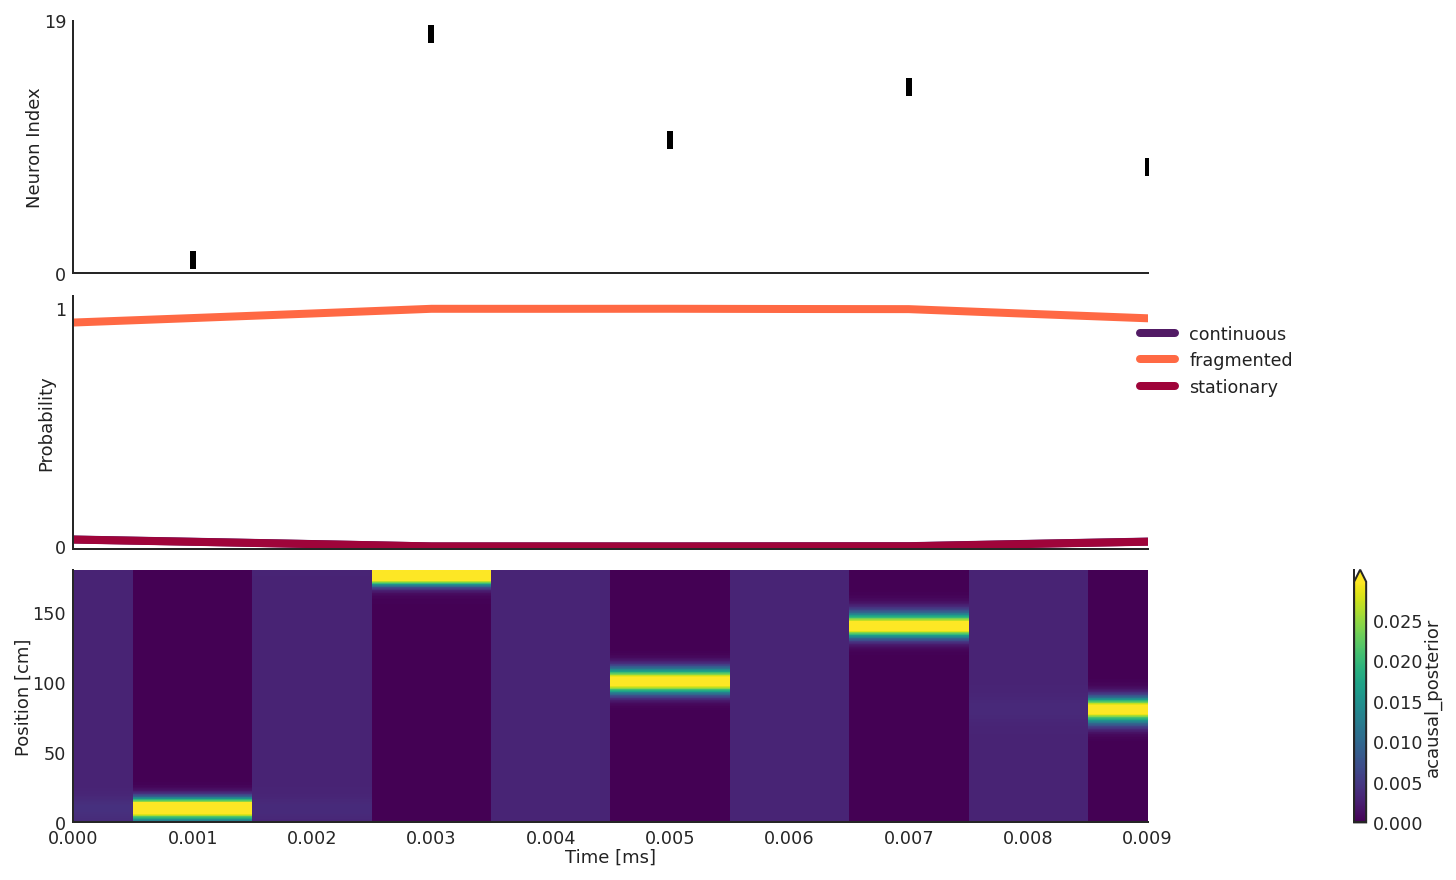

In [12]:
from replay_trajectory_classification.sorted_spikes_simulation import make_fragmented_replay

replay_time, test_spikes = make_fragmented_replay()

results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)

### Stationary-Continuous-Stationary

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


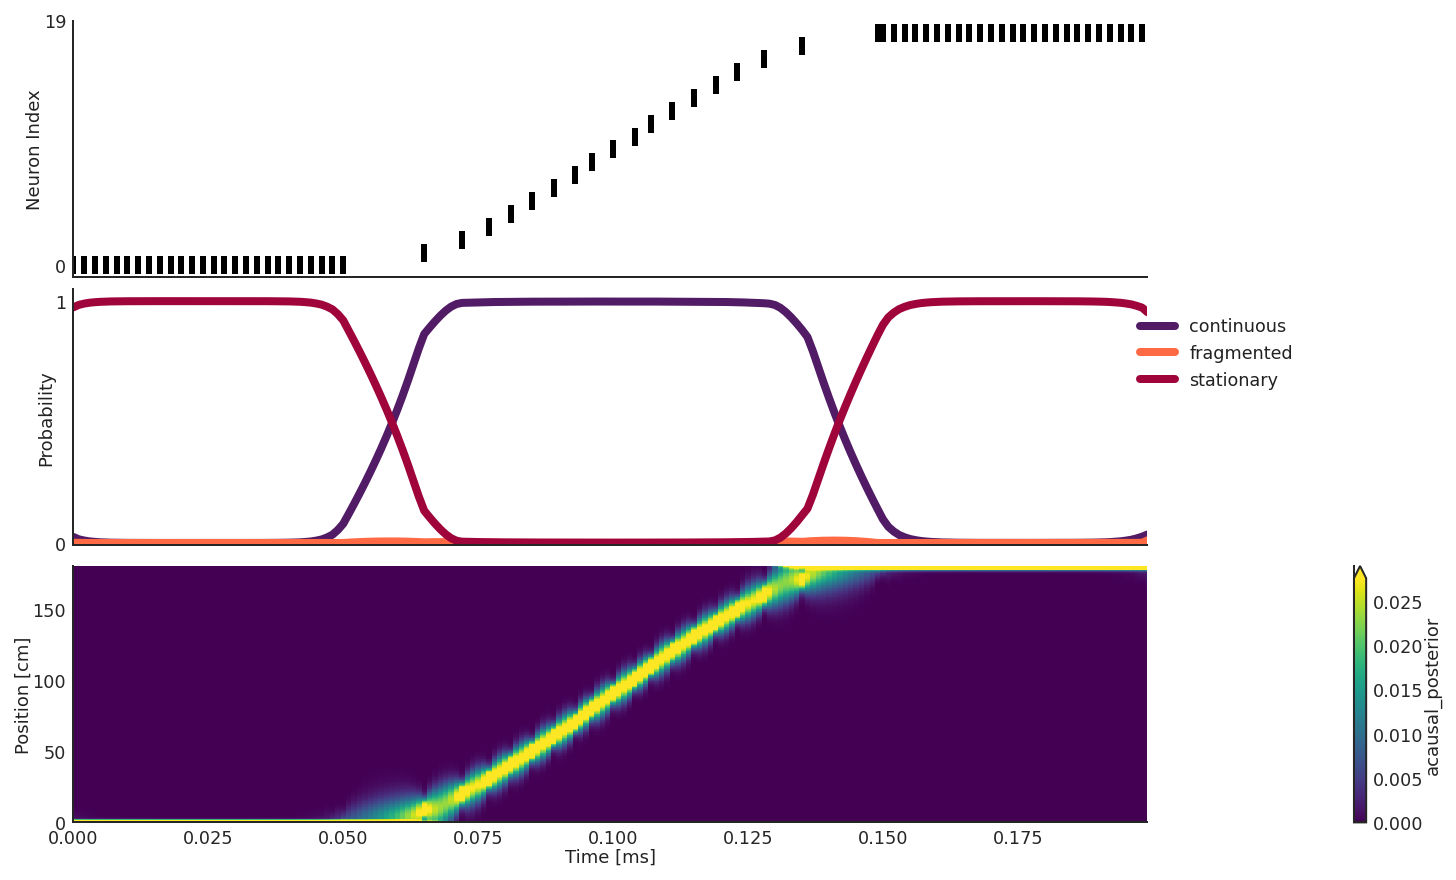

In [13]:
from replay_trajectory_classification.sorted_spikes_simulation import make_hover_continuous_hover_replay

replay_time, test_spikes = make_hover_continuous_hover_replay()

results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)

### Fragmented-Stationary-Fragmented

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


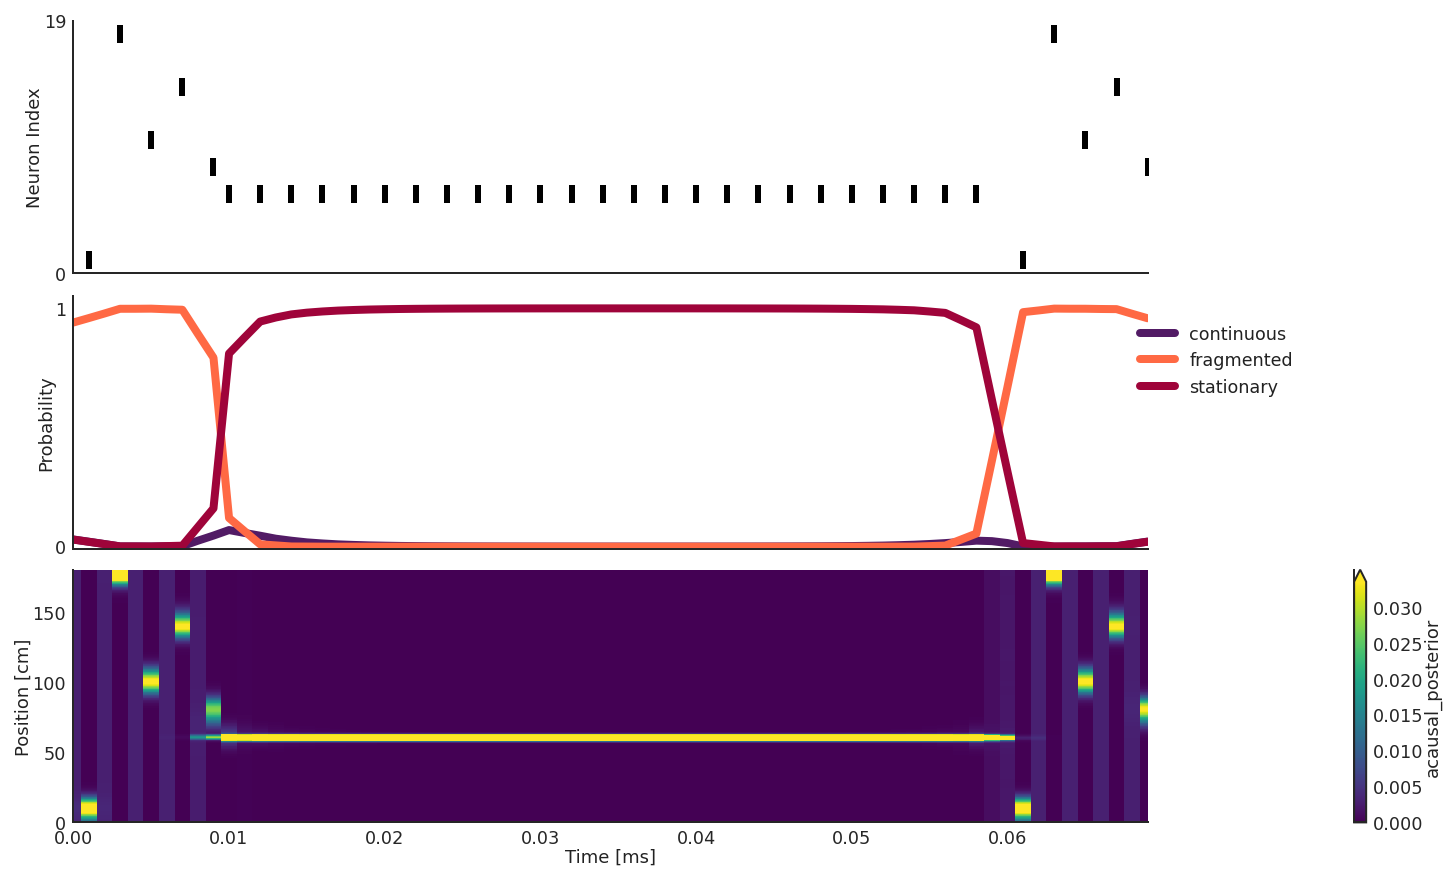

In [14]:
from replay_trajectory_classification.sorted_spikes_simulation import make_fragmented_hover_fragmented_replay

replay_time, test_spikes = make_fragmented_hover_fragmented_replay()

results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)

### Fragmented-Continuous-Fragmented

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


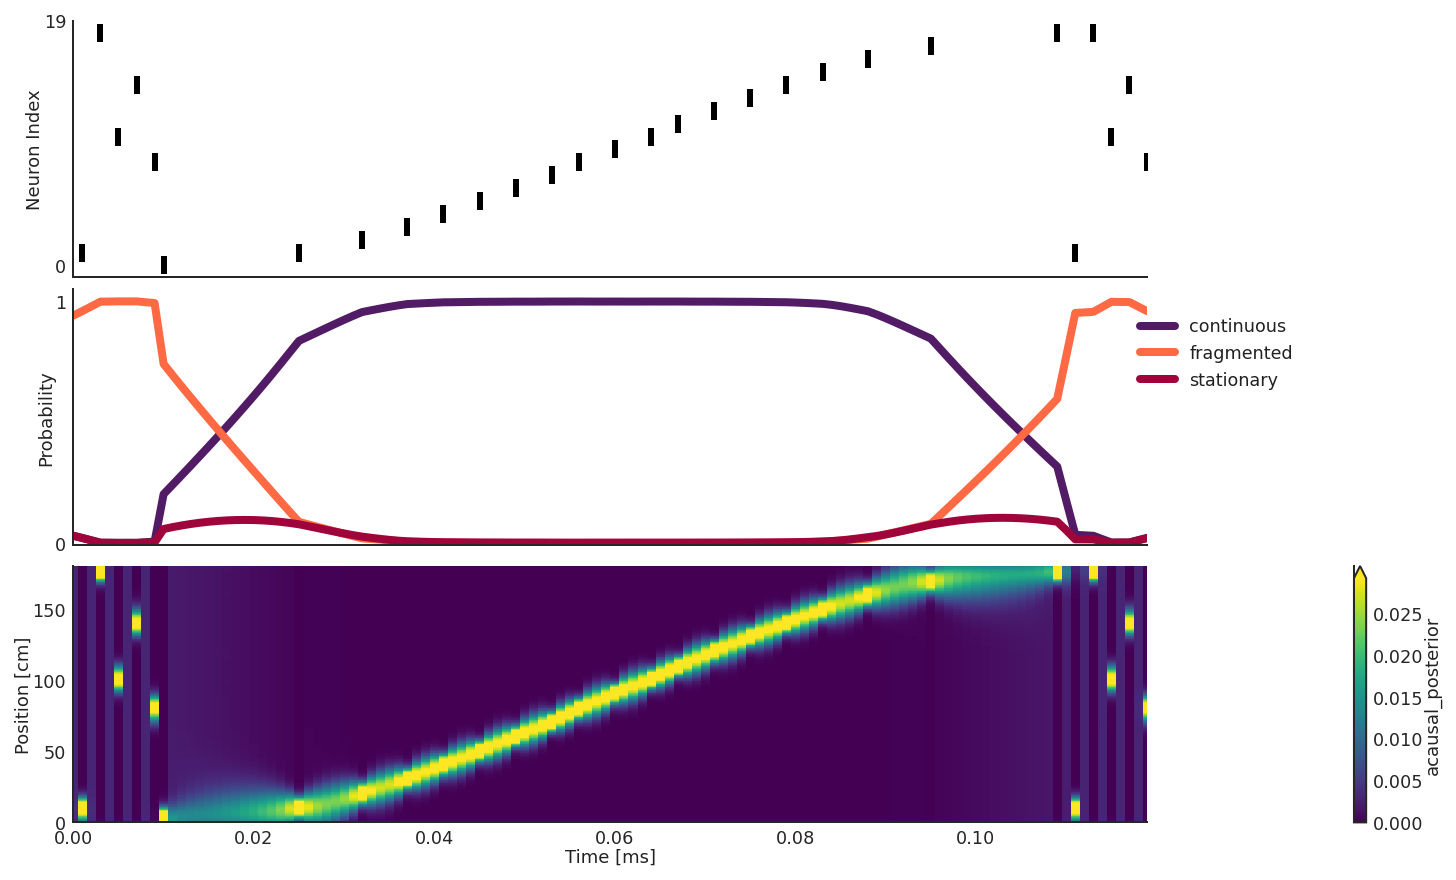

In [15]:
from replay_trajectory_classification.sorted_spikes_simulation import make_fragmented_continuous_fragmented_replay

replay_time, test_spikes = make_fragmented_continuous_fragmented_replay()

results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)